In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.optimize import brute, minimize, fmin

import ROOT
from find_SN_dir import *

from tqdm import tqdm, trange

Welcome to JupyROOT 6.24/06


In [2]:
pickle_path = "/media/linux_store/hep/data/pickles/event_pools.pkl"
ES_param = load_pdf_parameterized("/media/linux_store/hep/data/pdf/ES_gvkm_radiological_0201_pdf_param.dat", name="ES")
ES_numeric = load_pdf_numeric("/media/linux_store/hep/data/pdf/ES_gvkm_radiological_0201_pdf.dat", name="ES")

### Load in event pool
either by reading the root files, or reading pickle files (faster)

In [3]:
# directory = "/media/linux_store/hep/data/SN_radio/SN_ana_radiological/"



# ES_event_pool = load_SN_file("/media/linux_store/hep/data/ES_gvkm/ES_gvkm_radiological_0201.root",
#                              with_radio=True, return_nu_dir=True, show_progress=True)
# CC_event_pool = load_SN_file("/media/linux_store/hep/data/CC_gvkm/CC_gvkm_radiological_0201.root",
#                              with_radio=True, return_nu_dir=True, show_progress=True)



In [4]:
## Save pool as pickle
# import pickle
# with open(pickle_path, "wb") as f:
#     pickle.dump( [ES_event_pool, CC_event_pool], f)

In [3]:
## Read from pickle
import pickle
with open(pickle_path, "rb") as f:
    [ES_event_pool, CC_event_pool] = pickle.load(f)

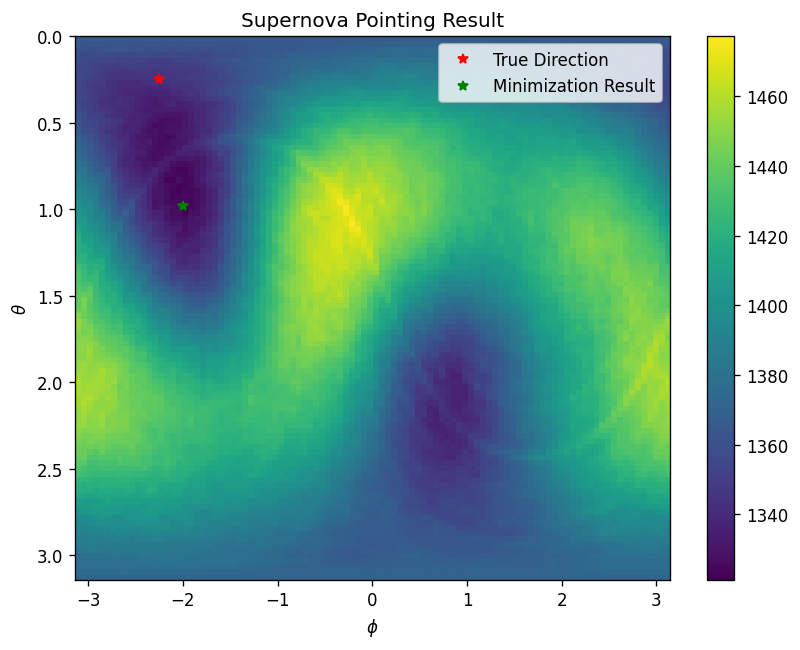

CPU times: user 964 ms, sys: 726 ms, total: 1.69 s
Wall time: 5.15 s


42.63652239158573

In [4]:
%%time
SN_pointer = SupernovaPointing([ES_numeric], [ES_event_pool, CC_event_pool],
                               synthetic=True, with_radio=True, synthetic_mixin=0.9)

def loss_func(x):
    return SN_pointer.loss(x)


res = brute(loss_func, ([0, np.pi], [-np.pi, np.pi]), Ns=100, full_output=True, workers=6, finish=None)
# res = minimize(loss, np.array([np.pi/2, 0]), args=args, method = 'Nelder-Mead')
# print(res[0])
# print(SN_pointer.truth_dir)
# print(f"Loss = {loss_func(SN_pointer.truth_dir)}")
details(SN_pointer, res)


In [4]:
TRIALS=1000

errors = []

for _ in trange(TRIALS):
    SN_pointer = SupernovaPointing([ES_numeric], [ES_event_pool, CC_event_pool],
                               synthetic=True, with_radio=True, synthetic_mixin=0.0)
    def loss_func(x):
        return SN_pointer.loss(x)
    res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=25, 
                full_output=False, workers=6, finish=fmin)
    errors.append(error(SN_pointer, res))

errors = np.asarray(errors)
plt.hist(errors[errors < 90])
plt.title(f"Angle between reco and truth SN direction (ES + radiological)\n68% Confidence Interval: {np.quantile(errors, 0.68):.2f}\nFlipped Supernovas: {errors[errors>90].size}")
plt.xlabel("Degrees")
np.quantile(errors, 0.68)

  6%|████▍                                                                            | 55/1000 [00:17<04:52,  3.23it/s]Process ForkPoolWorker-333:
Process ForkPoolWorker-336:
Process ForkPoolWorker-332:
Process ForkPoolWorker-331:
Process ForkPoolWorker-334:
Process ForkPoolWorker-335:
  6%|████▍                                                                            | 55/1000 [00:17<04:55,  3.20it/s]


KeyboardInterrupt: 

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:57<00:00,  4.21it/s]


Text(0.5, 1.0, '$\\Delta \\chi^2$')

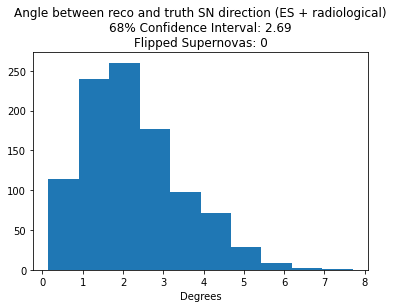

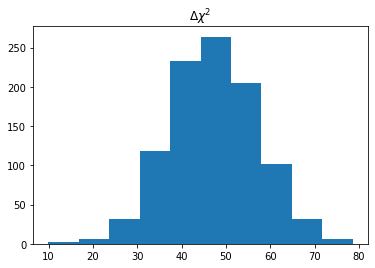

In [10]:
# Minimization
TRIALS=1000

errors = []
dchisq = []

for _ in trange(TRIALS):
    SN_pointer = SupernovaPointing([ES_param], [ES_event_pool, CC_event_pool],
                               synthetic=True, with_radio=True, synthetic_mixin=0.0)
    def loss_func(x):
        return SN_pointer.loss(x)
    first = minimize(loss_func, np.array([np.pi/2, 0]))
    second_direction_xyz = -1 * sphere_to_xyz(first.x)
    second_direction_sphere = xyz_to_sphere(second_direction_xyz)
    second = minimize(loss_func, second_direction_sphere)
    dchisq.append(abs(second.fun - first.fun))
    final_dir = second.x if second.fun < first.fun else first.x
    errors.append(error(SN_pointer, final_dir))


plt.figure()
errors = np.asarray(errors)
plt.hist(errors)
plt.title(
    f"""Angle between reco and truth SN direction (ES + radiological)
68% Confidence Interval: {np.quantile(errors, 0.68):.2f}
Flipped Supernovas: {errors[errors>90].size}"""
)
plt.xlabel("Degrees")
np.quantile(errors, 0.68)

plt.figure()
plt.hist(dchisq)
plt.title("$\Delta \chi^2$")

In [9]:
%%time
def mixin_test(mixin=0.0, trials=100):
    errors = []
    dchisq = [] # Todo: come up with some metric to quantify this distribution

    for _ in trange(trials, desc=f'Mix In Ratio = {mixin:.1f}'):
        SN_pointer = SupernovaPointing([ES_param], [ES_event_pool, CC_event_pool],
                                   synthetic=True, with_radio=True, synthetic_mixin=mixin)
        first = minimize(SN_pointer.loss, np.array([np.pi/2, 0]))
        second_direction_xyz = -1 * sphere_to_xyz(first.x)
        second_direction_sphere = xyz_to_sphere(second_direction_xyz)
        second = minimize(SN_pointer.loss, second_direction_sphere)
        dchisq.append(abs(second.fun - first.fun))
        final_dir = second.x if second.fun < first.fun else first.x
        errors.append(error(SN_pointer, final_dir))
    
    errors = np.asarray(errors)
    flipped = errors[errors>90].size
    quantile = np.quantile(errors, 0.68)
    return flipped, quantile

    
mixin_list = np.arange(0.1, 1.1, 0.1)
flipped_list = []
quantile_list = []
for mixin in mixin_list:
    flipped, quantile = mixin_test(mixin, 50)
    flipped_list.append(flipped)
    quantile_list.append(quantile)



Mix In Ratio = 1.0: 100%|███████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]

CPU times: user 3min 56s, sys: 27.3 s, total: 4min 24s
Wall time: 3min 50s


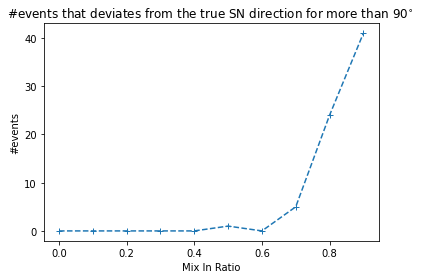

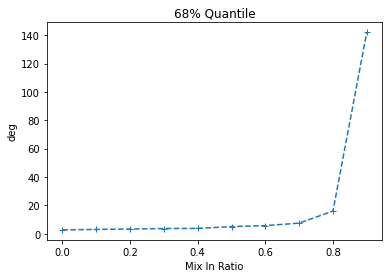

In [19]:

plt.plot(mixin_list, flipped_list, '+--')
plt.title("#events that deviates from the true SN direction for more than $90^{\circ}$ ")
plt.xlabel("Mix In Ratio")
plt.ylabel("#events")
plt.show()
plt.plot(mixin_list, quantile_list, '+--')
plt.title("68% Quantile")
plt.xlabel("Mix In Ratio")
plt.ylabel("deg")
plt.show()

In [6]:
from parsl import python_app, Config
from parsl.executors.threads import ThreadPoolExecutor
import parsl
parsl.clear()
local_threads = Config(
    executors=[
        ThreadPoolExecutor(
            max_threads=6,
            label='local_threads'
        )
    ]
)
parsl.load(local_threads)


In [10]:
%%time

@python_app
def mixin_test(mixin=0.0, trials=100):
    print(f"Beginning... mixin = {mixin}")
    errors = []
    dchisq = [] # Todo: come up with some metric to quantify this distribution

#     for _ in trange(trials, desc=f'Mix In Ratio = {mixin:.1f}'):
    for _ in range(trials):
        SN_pointer = SupernovaPointing([ES_param], [ES_event_pool, CC_event_pool],
                                   synthetic=True, with_radio=True, synthetic_mixin=mixin)
        first = minimize(SN_pointer.loss, np.array([np.pi/2, 0]))
        second_direction_xyz = -1 * sphere_to_xyz(first.x)
        second_direction_sphere = xyz_to_sphere(second_direction_xyz)
        second = minimize(SN_pointer.loss, second_direction_sphere)
        dchisq.append(abs(second.fun - first.fun))
        final_dir = second.x if second.fun < first.fun else first.x
        errors.append(error(SN_pointer, final_dir))
    
    errors = np.asarray(errors)
    flipped = errors[errors>90].size
    quantile = np.quantile(errors, 0.68)
    print(f"Ending... mixin = {mixin}")
    return flipped, quantile

results =  []
for mixin in np.arange(0, 1, 0.1):
    result = mixin_test(mixin, 50)
    results.append(result)

for r in results:
    print(r.result())

Beginning... mixin = 0.0Beginning... mixin = 0.1

Beginning... mixin = 0.2Beginning... mixin = 0.30000000000000004

Beginning... mixin = 0.4
Beginning... mixin = 0.5
Ending... mixin = 0.0
Beginning... mixin = 0.6000000000000001
(0, 3.0467945214901317)
Ending... mixin = 0.1
Beginning... mixin = 0.7000000000000001
(0, 3.1333039870744797)
Ending... mixin = 0.2
Beginning... mixin = 0.8
(0, 3.0455279377477726)
Ending... mixin = 0.5
Beginning... mixin = 0.9
Ending... mixin = 0.4
Ending... mixin = 0.30000000000000004
(0, 3.5207447957908378)
(0, 4.699750708900986)
(0, 5.058694302478794)
Ending... mixin = 0.7000000000000001
Ending... mixin = 0.6000000000000001
(2, 6.745908489270176)
(6, 7.829972113173637)
Ending... mixin = 0.8
(11, 13.670622012577248)
Ending... mixin = 0.9
(21, 124.38148972700685)
CPU times: user 4min 12s, sys: 1min 4s, total: 5min 16s
Wall time: 3min 56s


In [8]:
%%time
import parsl
import time
from parsl import python_app

# parsl.load()

# Map function that returns double the input integer
@python_app
def app_random(i):
    import random
    time.sleep(10)
    return random.random()+i

results =  []
for i in range(0, 10):
    x = app_random(i)
    results.append(x)

for r in results:
    print(r.result())

0.02704106474115653
1.0417582335329056
2.4817747024365726
3.588086567399165
4.697300984429839
5.658365641301511
6.626527811677995
7.757333880844748
8.72623119599027
9.88587490880042
CPU times: user 38 ms, sys: 20.7 ms, total: 58.7 ms
Wall time: 20 s


In [8]:
round(0.3*10)

3